In [1]:
import torch
from spin import create_J_matrix, SpinConfiguration
from modeling import IsingEnergyModel, IsingSimpleFlowModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
N = 3
J = create_J_matrix(N, sigma=1)

trained_model = IsingSimpleFlowModel(N=N).to(device)
trained_model.load_state_dict(torch.load("model_no_TB_state_dict.pt", map_location=device))

random_model = IsingSimpleFlowModel(N=N).to(device)

energy_model = IsingEnergyModel(J=J, device=device)

In [4]:
def create_empty_state(N):
    return torch.zeros(2*(N**2), dtype=torch.float32, requires_grad=True)

def create_input_batch(N, batch_size, device="cpu"):
    return torch.cat([create_empty_state(N).reshape(1,-1)] * batch_size, dim=0).to(device)

In [10]:
def spin_to_state(spin):
    N = spin.values.shape[0]
    state = torch.zeros((2*(N**2)))
    state[:N**2][torch.where(spin.values.flatten()==1)] = 1
    state[N**2:][torch.where(spin.values.flatten()==-1)] = 1
    return state

def state_to_spin(state):
    N = int(np.sqrt(state.shape[0]/2))
    values = torch.zeros(N**2, dtype=torch.float32)
    values[torch.where(state[:N**2]==1)] = 1
    values[torch.where(state[N**2:]==1)] = -1
    spin = SpinConfiguration(N, values.reshape(N, N))
    return spin

### Exact partition function

For non physical reward function (-10 * energy) if energy < 0

In [5]:
base_values = np.array([-1]*N**2, dtype=int)
partition_function = 0

for i in range(2**(N**2)):
    new_spins = 2 * np.array([int(char) for char in np.binary_repr(i)]) - 1
    spin_values = base_values.copy()
    spin_values[-new_spins.shape[0]:] = new_spins
    spin_values = spin_values.reshape(N,N)
    
    spin = SpinConfiguration(N=N, values=spin_values)
    energy = spin.get_energy(J)
    relative_prob = 10 * np.log(np.exp(-1 *energy))
    if relative_prob > 0:
        partition_function += relative_prob

In [6]:
partition_function

tensor(18000.)

In [7]:
exact_prob_dict = {}
for i in range(2**(N**2)):
    new_spins = 2 * np.array([int(char) for char in np.binary_repr(i)]) - 1
    spin_values = base_values.copy()
    spin_values[-new_spins.shape[0]:] = new_spins
    spin_values = spin_values.reshape(N,N)
    
    spin = SpinConfiguration(N=N, values=spin_values)
    energy = spin.get_energy(J)
    probability = -10 * energy/partition_function
    
    if probability > 0:
        if str(energy.item()) in exact_prob_dict.keys():
            exact_prob_dict[str(energy.item())] += probability
        else:
            exact_prob_dict[str(energy.item())] = probability

In [38]:
for k in exact_prob_dict.keys():
    exact_prob_dict[k] = exact_prob_dict[k].item()

In [39]:
exact_prob_dict

{'-36.0': 0.03999999910593033,
 '-20.0': 0.20000000298023224,
 '-12.0': 0.3199998438358307,
 '-4.0': 0.43999919295310974}

### Random model distribution

In [15]:
state = create_input_batch(N=N, batch_size=10000, device=device)

random_model.eval()
for _ in range(N**2):
    state = random_model.make_choice(state)
    
spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

In [16]:
random_prob_dict = {}
for e in energies:
    if str(e.item()) in random_prob_dict.keys():
        random_prob_dict[str(e.item())] += 1
    else:
        random_prob_dict[str(e.item())] = 1

In [17]:
random_prob_dict

{'12.0': 2021,
 '-4.0': 3858,
 '-12.0': 965,
 '4.0': 2760,
 '-36.0': 33,
 '-20.0': 363}

### Trained model distribution

In [18]:
state = create_input_batch(N=N, batch_size=10000, device=device)

trained_model.eval()
for _ in range(N**2):
    state = trained_model.make_choice(state)
    
spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

In [19]:
trained_prob_dict = {}
for e in energies:
    if str(e.item()) in trained_prob_dict.keys():
        trained_prob_dict[str(e.item())] += 1
    else:
        trained_prob_dict[str(e.item())] = 1

In [20]:
trained_prob_dict

{'-12.0': 647, '-20.0': 2951, '-36.0': 6217, '-4.0': 185}

### Comparison

In [28]:
random_model_dist = [[float(k)] * random_prob_dict[k] for k in random_prob_dict.keys()]
random_model_dist = [item for sublist in random_model_dist for item in sublist]

In [34]:
trained_model_dist = [[float(k)] * trained_prob_dict[k] for k in trained_prob_dict.keys()]
trained_model_dist = [item for sublist in trained_model_dist for item in sublist]

In [42]:
exact_dist = [[float(k)] * int(exact_prob_dict[k] * 10000) for k in exact_prob_dict.keys()]
exact_dist = [item for sublist in exact_dist for item in sublist]

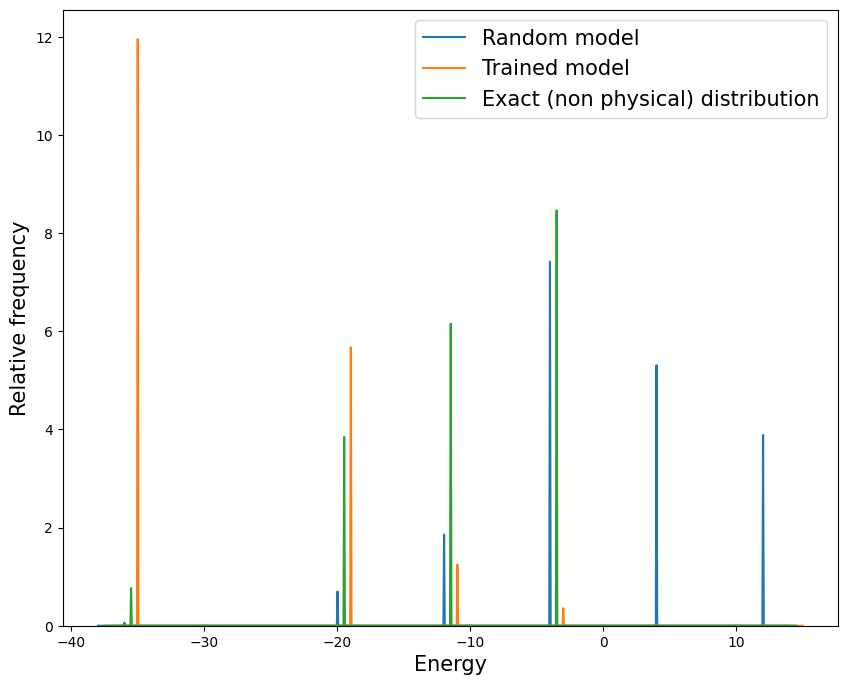

In [50]:
fig, ax = plt.subplots(figsize=(10,8))

yrandom, xrandom = np.histogram(random_model_dist, bins=1000, range=(-38, 14), density=True)
ytrained, xtrained = np.histogram(trained_model_dist, bins=1000, range=(-38, 14), density=True)
yexact, xexact = np.histogram(exact_dist, bins=1000, range=(-38, 14), density=True)

ax.plot(xrandom[1:], yrandom, label="Random model")
ax.plot(xtrained[1:] + 1, ytrained, label="Trained model")
ax.plot(xexact[1:] + 0.5, yexact, label="Exact (non physical) distribution")

ax.legend(fontsize=15)
ax.set_ylim([0, None])
ax.set_xlabel("Energy", fontsize=15)
ax.set_ylabel("Relative frequency", fontsize=15)
plt.show()